## Problem Statement:

An online question and answer platform has hired you as a data scientist to identify the best question authors on the platform. This identification will bring more insight into increasing the user engagement. Given the tag of the question, number of views received, number of answers, username and reputation of the question author, the problem requires you to predict the upvote count that the question will receive.

## Solution Approach:

Crowdsourced online content platforms have a constant need to identify the best content in time to appropriately promote and thereby improve the engagement at the website. This data challenge hosted by 'Analytics Vidhya' involves a similar problem of predicting the upvote count for a queries posted and identify the parameters that affect it the most.

The evaluation metric for this competition is RMSE (root mean squared error).

After trying out multiple regression models and different data preparation approaches my final submission obtained an RMSE of 890 and I ranked 29th on Public Leaderboard.

In this notebook I have mostly focussed on my final submission but in the due course I will also mention some of the alternative techniques/approaches I used and how they performed.

Remainder of the notebook is divided into following sections.

1. Environment Setup
2. Exploratory Data Analysis and Feature Selection
3. Model Training
4. Prediction on Test Data

### 1. Environment Setup

#### Import required Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns; sns.set(style="ticks", color_codes=True)
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

#### Read Data Files

In [2]:

path = r"D:\Projects\Hackathon\AV\upvotes"
train_data = pd.read_csv(path+'\\train_NIR5Yl1.csv')
test_data = pd.read_csv(path+'\\test_8i3B3FC.csv')

### 2. Exploratory Data Analysis and Feature Selection

After initial analysis of the training data and fitting few regression models I observed that in most cases upvotes greater than 600000 are giving high residuals and distorting the fit. Hence I considered them as outliers and considered data with upvotes less than 600000 for training models.
Also depending on how many times a 'Username' appears on the dataset I created a new feature 'User Frequency' but it couldn't improve performance of any of the models and hence I dropped 'Username' along with 'ID' from the dataset.
I used seaborn pairplot to visualize the distribution of remaing parameters and their relationship.

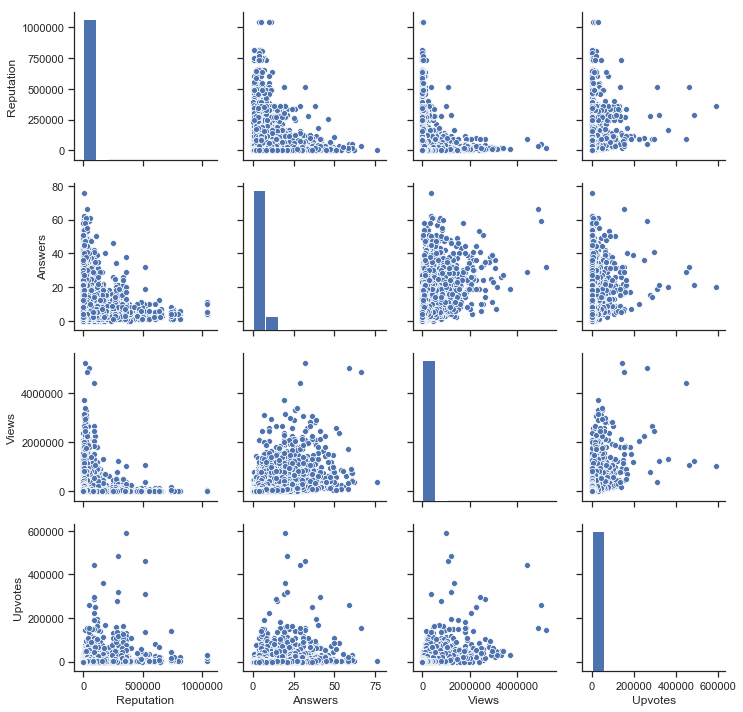

In [3]:
train_data.drop(['Username','ID'],axis=1,inplace=True)   
train_data = train_data[train_data['Upvotes']<600000] 
sns.pairplot(train_data)

From the pair plot we can see that 'Reputation' vs 'Answers' and 'Reputation' vs 'Views' have hyperbolic relationship which hints towards a strong possibility of their product being important features.
To verify that I created two new features 'Rep-views' and 'Rep-ans' and plotted them against 'Upvotes'.

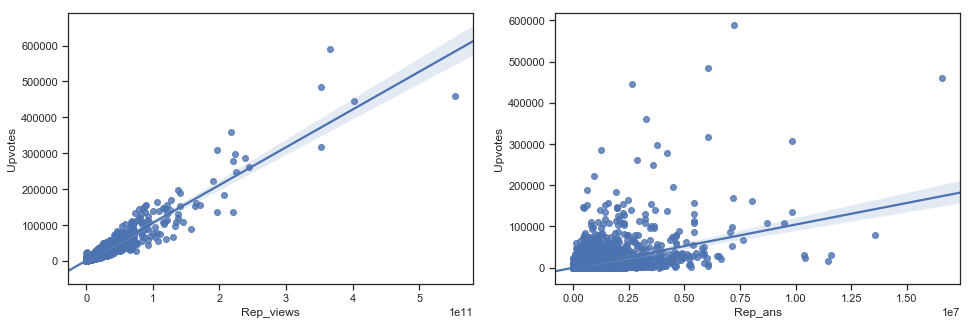

In [5]:
train_data['Rep_views'] = train_data['Reputation']*train_data['Views']
train_data['Rep_ans'] = train_data['Reputation']*train_data['Answers']
train_data['Rep_views_sq'] = train_data['Rep_views']**2
plt.figure(figsize=[16,5])
plt.subplot(121)
sns.regplot('Rep_views','Upvotes',data=train_data)
plt.subplot(122)
sns.regplot('Rep_ans','Upvotes',data=train_data)

The first plot clearly shows a strong correlation between 'Rep-views' and 'Upvotes' whereas though the correlation between 'Rep-ans' and 'Upvotes' are not that strong, still it's worth trying out as input feature.
These observations were further validated when I used polynomial features with interaction allowed and I saw significant coefficient values for 'Rep-views', 'Rep-ans' and squared term of 'Rep-views'.
The study showed that relation between 'Rep-views' and 'Upvotes' is slightly quadratic and hence included it's squared term 'Rep_views_sq' as an additional feature.
I didn't stick to feature transfomation technique using polynomial features as even with regularization with both Lasso and Ridge the models were getting overfitted. 

### 3. Model Training

I tried with different algorithms like GBM Regressor, Random Forest Regressor, Support Vector Regressor, LassoLars, Ridge Regression etc. with different feature combinations and hyperparameter settings.
All the models were initially evaluated with 80:20 train-test split and then after selecting important features and hyperparameter tuning entire train data was used to fit each model and the models were re-evaluated by submitting predictions on test data.
After comparison of all models Ridge regression with alpha=19000 was found to be the best fit for this data.

#### Data Transformation

In this notebook I have only shown the final model training without any cross-validation. The input variables are scaled using standard scaling for regularization to work properly

In [6]:
sc_1 = StandardScaler()
X = train_data[['Rep_views','Rep_views_sq','Rep_ans','Views','Reputation']]
y = train_data['Upvotes']
X = sc_1.fit_transform(X)

#### Ridge Regression Model Fit

0.9095107407775607
1064141.746099917
[ 2.70369823e+03  3.55787548e+02  1.38419821e+02  1.64274007e+02
 -2.57301600e+00] 335.64215074353723


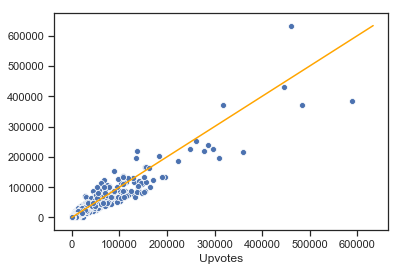

In [7]:
reg = Ridge(alpha=19000).fit(X, y)
print(reg.score(X, y))
y_pred1 = reg.predict(X)
lmt = max(max(y),max(y_pred1))
print(mean_squared_error(y, y_pred1))
print(reg.coef_,reg.intercept_)
sns.lineplot([0,lmt],[0,lmt],color='orange')
sns.scatterplot(y,y_pred1)

# 4. Prediction on Test Data

Finally the fitted model is used to predict upvotes on the unlabelled test data after data preparation.
Following two logical constraints are added to further refine the predicted values.
1. Upvotes cannot be negative
2. Upvotes cannot be more than #Views

In [8]:
test_data['Rep_views'] = test_data['Reputation']*test_data['Views']
test_data['Rep_views_sq'] = test_data['Rep_views']**2
test_data['Rep_ans'] = test_data['Reputation']*test_data['Answers']
Xt = test_data[['Rep_views','Rep_views_sq','Rep_ans','Views','Reputation']]
Xt = sc_1.transform(Xt)
y_pred_t = reg.predict(Xt)
y_pred_t = y_pred_t*(y_pred_t>0)
y_pred_final = y_pred_t*(y_pred_t<test_data['Views'])+test_data['Views']*(y_pred_t>=test_data['Views'])

In [9]:
test_data['Upvotes'] = y_pred_final
result = test_data[['ID','Upvotes']]
result.to_csv(path+'\\final_submission.csv',index=False)